In [1]:
import os
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import math
import imageio
import glob
from skimage import io
import albumentations as A
import json
import random
from numpy import savez_compressed
import shutil
from sklearn.model_selection import train_test_split

from pycocotools.coco import COCO
from PIL import Image
%matplotlib inline

In [2]:
def appenCatIdtoBbox(BboxListArr,catID):
    for element in range(0,len(BboxListArr)):
        BboxListArr[element].append(str(catID[element]))
    
    return BboxListArr

def imageTransformation(imgPath,image,BboxListArr,SegAndKeypoints,transform):
    height, width = cv2.imread(imgPath).shape[:2]
    transformed = transform(image=image, bboxes=BboxListArr, keypoints=SegAndKeypoints)
    transformed_image = transformed['image']
    transformed_keypoints = transformed['keypoints']
    transformed_bboxes = transformed['bboxes']
    transformed_keypoints = np.array(transformed_keypoints)
    
    return transformed,transformed_image,transformed_keypoints,transformed_bboxes,height,width

def extractKeypoints(validKeypoints,transformed_keypoints,listOfkpVisibility,maxNumOfKeypoints, AllKeypoints):
    fileID = 0
    if validKeypoints != 0:
        keyPoints = transformed_keypoints[-validKeypoints:]
        transformed_keypoints = transformed_keypoints[:-validKeypoints]
        AllKeypoints = []
        for ind in range(0,len(keyPoints)):
            AllKeypoints.append(keyPoints[ind][0])
            AllKeypoints.append(keyPoints[ind][1])
            AllKeypoints.append(listOfkpVisibility[ind])

    for indx in range(0,maxNumOfKeypoints - validKeypoints):
        AllKeypoints.append(0)
        AllKeypoints.append(0)
        AllKeypoints.append(0)
    
    return AllKeypoints,transformed_keypoints,AllKeypoints

def extractPolygons(transformed_keypoints,listOfSegCount):
    keepTrackOfIndex = 0
    
    AllSegmentations = []
    transformed_keypoints = transformed_keypoints.flatten()
    for ind in range(0,len(listOfSegCount)):
        listOfPoints = transformed_keypoints[keepTrackOfIndex:keepTrackOfIndex+listOfSegCount[ind]]
        keepTrackOfIndex = keepTrackOfIndex + listOfSegCount[ind]
        AllSegmentations.append(listOfPoints.tolist())
        
    return AllSegmentations

def objDevelopment(augCOCOjsonAnns,eachAnno,catagoryID,hasKeypoints,hasSeg,hasBBox,ImageID,polySegs,bbox,area,AllKeypoints,validKeypoints):
    
    if (hasKeypoints == True and hasSeg == True and hasBBox == True) or (hasKeypoints == True and hasSeg == True):
        objAug = {
            "id":str(0),
            "image_id":ImageID,
            "category_id":catagoryID,
            "segmentation": polySegs,
            "bbox": bbox,
            "ignore":0,
            "iscrowd":0,
            "area": area,
            "keypoints": AllKeypoints,
            "num_keypoints": validKeypoints
          }
    elif hasKeypoints == False and hasSeg == False and hasBBox == True:
        objAug = {
            "id":str(0),
            "image_id":ImageID,
            "category_id":catagoryID,
            "bbox": bbox,
            "ignore":0,
            "iscrowd":0,
            "area": area,
          }
    elif (hasKeypoints == False and hasSeg == True and hasBBox == True) or (hasKeypoints == False and hasSeg == True and hasBBox == False):
        objAug = {
            "id":str(0),
            "image_id":ImageID,
            "category_id":catagoryID,
            "segmentation": polySegs,
            "bbox": bbox,
            "ignore":0,
            "iscrowd":0,
            "area": area,
          }
    augCOCOjsonAnns.append(objAug)
    
    return augCOCOjsonAnns

def JsonObjCreation(catID,hasKeypoints,hasSeg,hasBBox,ImageID,AllSegmentations,transformed_bboxes,listOfArea,AllKeypoints,validKeypoints):
    augCOCOjsonAnns = []
    for eachAnno in range(0,len(catID)):
        augCOCOjsonAnns = objDevelopment(augCOCOjsonAnns,eachAnno,catID[eachAnno],hasKeypoints,hasSeg,hasBBox,ImageID,[AllSegmentations[eachAnno]],list(transformed_bboxes[eachAnno][:4]),listOfArea[eachAnno],AllKeypoints,validKeypoints)
  
    return augCOCOjsonAnns

In [3]:
def augImage(hasSeg,hasBBox,transform,transformCount, ImgId, BboxListArr, SegAndKeypoints, listOfSegCount,listOfkeypoints, catID, maxNumOfKeypoints, listOfkpVisibility, hasKeypoints, validKeypoints, imgPath, outPath, imgName, listOfArea,maxID): 
    ## Function used to augment Images and save them as per the COCO Standards
    ## 1. Append class label in BBox List
    ## 2. Transform Image and get list of each annotation style
    ## 3. Albumentation dont process polygon segmentations, so transform them as keypoints
    ## https://albumentations.ai/
    ## 4. Seperate Segmentations from the transformed Keypoints
    ## 5. Save keypoints as per its visibility. TO maintain the count of maximum number of keypoints append some dummy with visibility 0.
    ## https://cocodataset.org/#format-data
    ## 6. Saving the augmented JSON by making a JSON object
    ## 7. Save the augmented image in the output directory
    
    
    AllKeypoints = []
    
    BboxListArr = appenCatIdtoBbox(BboxListArr,catID)

    imgPath = str(imgPath)+str(imgName)
    image = cv2.imread(imgPath)
    image = np.array(image)
    transformed,transformed_image,transformed_keypoints,transformed_bboxes,height,width = imageTransformation(imgPath,image,BboxListArr,SegAndKeypoints,transform)
    
    if hasKeypoints:
        AllKeypoints,transformed_keypoints,AllKeypoints = extractKeypoints(validKeypoints,transformed_keypoints,listOfkpVisibility,maxNumOfKeypoints, AllKeypoints)

    if hasSeg:
        AllSegmentations = extractPolygons(transformed_keypoints,listOfSegCount)

    ImageID = maxID + int(str(ImgId)+str(transformCount))
    augCOCOjsonAnns = JsonObjCreation(catID,hasKeypoints,hasSeg,hasBBox,ImageID,AllSegmentations,transformed_bboxes,listOfArea,AllKeypoints,validKeypoints)
    newImageName = str(ImageID)+str(transformCount)+str(imgName)
    cv2.imwrite(outPath+'/'+newImageName, transformed_image)
    
    return newImageName, augCOCOjsonAnns, ImageID, height, width

def editFileName(fname):
    ## This function manupilates the label-studio image name in mini JSON
    
    head, tail = os.path.split(fname)
    tail = tail.split("-")     #Use this if you have the same images which you uploaded on LabelStudio. If you do not have the images, take images from Label studio coco format (In that case do not use this line).
    newFname = tail[1]

    return newFname


In [4]:
def startAugmentation(image_anns,augTransforms,hasSeg,hasBBox,ImgId, listOfAllBbox, listOfAllSeg, listOfSegCount,listOfkeypoints, listOfcatID, maxNumOfKeypoints, listOfkpVisibility, hasKeypoints, totalCountOfValidKeypoint,ImageFolderPath, path_toAug, fileName, listOfArea,maxID,image_def):
    transformCount = 0
    for line in augTransforms:
        transformCount+=1
        augStyle = "A."+str(line.strip())
        transform = A.Compose(
          [eval(augStyle)],
          bbox_params=A.BboxParams(format="coco"),
          keypoint_params=A.KeypointParams(format="xy"),
        )
        newImageName, augCOCOJsonAnnos, NewImageID, height, width = augImage(hasSeg,hasBBox,transform,transformCount,ImgId, listOfAllBbox, listOfAllSeg, listOfSegCount,listOfkeypoints, listOfcatID, maxNumOfKeypoints, listOfkpVisibility, hasKeypoints, totalCountOfValidKeypoint,ImageFolderPath, path_toAug, fileName, listOfArea,maxID)
        objImgDesc = {
            "width":width,
            "height":height,
            "id":NewImageID,
            "file_name":newImageName
        }
        
        for CountAugs,valAugs in enumerate(augCOCOJsonAnnos):
            image_anns.append(valAugs)
        image_def.append(objImgDesc)
    return image_def,image_anns

In [5]:
def createMasks(coco,image_id,pathToDirectory,fileName):
    img = coco.imgs[image_id]
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
    cv2.imwrite(pathToDirectory+'/'+str(fileName),mask)


In [6]:
def makeListOfAnnos(valAnnos,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfAllSeg):
    ## Extract the annotation from the JSON array
    
    if "segmentation" in valAnnos:
        poly = valAnnos['segmentation'][0]
        for i in range(0, len(poly)-1, 2):
            listOfAllSeg.append((poly[i], poly[i+1]))
        listOfSegCount.append(len(poly))

    if "bbox" in valAnnos:
        listOfAllBbox.append(valAnnos['bbox'])

    if "category_id" in valAnnos:
        listOfcatID.append(valAnnos['category_id'])

    if "area" in valAnnos:
        listOfArea.append(valAnnos['area'])
        
    return listOfSegCount,listOfAllSeg, listOfAllBbox, listOfcatID, listOfArea


def augmentImage(ImgId,listOfSegCount,listOfAllSeg, listOfAllBbox,listOfkeypoints, listOfcatID, listOfArea,path_toAug,json_file,ImageFolderPath,OutputFolder,fileName,image_anns,image_def,maxID):
    ## Make the keypoint List
    ## Load the augmentations from the file
    ## Make augmentations
    ## Save the JSON and the image
    
    imgPath = str(ImageFolderPath)+str(fileName)
    image = cv2.imread(imgPath)
    totalCountOfValidKeypoint = 0
    listOfkpVisibility = []
    
    
    if hasKeypoints == True:
        obkps = listOfkeypoints
        for i in range(0, len(obkps)-1, 3):
            listOfkpVisibility.append(obkps[i+2])
            if obkps[i+2] != 0:
                totalCountOfValidKeypoint += 1
                listOfAllSeg.append((obkps[i], obkps[i+1]))

    image_def,image_anns = startAugmentation(image_anns,augTransforms,hasSeg,hasBBox,ImgId, listOfAllBbox, listOfAllSeg, listOfSegCount,listOfkeypoints, listOfcatID, maxNumOfKeypoints, listOfkpVisibility, hasKeypoints, totalCountOfValidKeypoint,ImageFolderPath, path_toAug, fileName, listOfArea,maxID,image_def)

    print('saved',path_toAug+'/'+fileName)
    cv2.imwrite(path_toAug+'/'+fileName, image)
    return image_def,image_anns
    
def innitializeArrays(listOfAllSeg,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfkeypoints):
    listOfAllSeg = []
    listOfAllBbox = []
    listOfcatID = []
    listOfArea = []
    listOfSegCount = []
    listOfkeypoints = []
    
    return listOfAllSeg,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfkeypoints
    


In [7]:
def basicAnnotationInfo(imgs_anns,listOffile_name,maxID):
    for CountImageName,valImageName in enumerate(imgs_anns['images']):
        if "file_name" in valImageName:
            listOffile_name.append(valImageName['file_name'])
        if "id" in valImageName:
            if maxID < int(valImageName['id']):
                maxID = int(valImageName['id'])
   
    return listOffile_name,maxID

def assignAnnIDs(maxID,imgs_anns):
    idCount = maxID + 1000
    for CountIDCount,valIDCount in enumerate(imgs_anns['annotations']):
        valIDCount['id'] = idCount
        idCount+=1
        valIDCount['bbox'] = valIDCount['bbox'][:4]
        
    return imgs_anns

def appendAugJSONtoOriginalJSON(image_anns,image_def,imgs_anns):
    for CountFinal,valFinal in enumerate(image_anns):
        imgs_anns['annotations'].append(valFinal)
        
    for CountDef,valDef in enumerate(image_def):
        imgs_anns['images'].append(valDef)
    
    return imgs_anns

def finalizeJson(imgs_anns,OutputFolder,directory):
    imagesCount=0

    path_1 = os.path.join(OutputFolder, directory)
    os.mkdir(path_1)
    
    with open(path_1 + "/"+directory+".json", "w") as outfile:
        json.dump(imgs_anns, outfile)

    print("Coco JSON Saved!")
    
    pathToMaskDir = os.path.join(OutputFolder, 'Masks')
    os.mkdir(pathToMaskDir)
    for CountImgCount,valImgCount in enumerate(imgs_anns['images']):
        imagesCount+=1
        createMasks(COCO(path_1 + "/"+directory+".json"), valImgCount['id'],pathToMaskDir,str(valImgCount['file_name']))
    print("Total Number Of Images after Augmentation",imagesCount)
    
    return imgs_anns

In [8]:
def AugmentCOCO(imgs_anns,path_toAug,json_file,ImageFolderPath,OutputFolder,hasKeypoints,hasBBox,hasSeg,Augmentation,maxNumOfKeypoints):
    ## 1. Extract the lists from previous JSON structure
    ## 2. Convert the polugon segmentations to keypoints
    ## 3. Make Augmentations
    ## 4. Save the COCO Augmented JSON structure and the images
    
    listOffile_name = []
    image_anns = []
    image_def = []
    listOfAllSeg = []
    listOfAllBbox = []
    listOfcatID = []
    listOfArea = []
    listOfSegCount = []
    listOfkeypoints = []
    
    
    ImgId = imgs_anns['annotations'][0]["image_id"]
    maxID = -1
    imageCount = 0
    
    listOffile_name,maxID = basicAnnotationInfo(imgs_anns,listOffile_name,maxID)
    baseImageCount = len(listOffile_name)
    lenOfAnnotations = len(imgs_anns['annotations'])
    

    for CountAnnos,valAnnos in enumerate(imgs_anns['annotations']):
        if valAnnos['image_id'] == ImgId or len(listOfcatID) <=1: #Run if it is a new file and make its lists
            fileName = listOffile_name[imageCount]
            filePath = ImageFolderPath + str(fileName)
            image = cv2.imread(filePath)
            
            if hasKeypoints == True:
                listOfkeypoints = valAnnos['keypoints']
            
            if len(listOfcatID) <=1 and valAnnos['image_id'] != ImgId:
                image_def,image_anns = augmentImage(ImgId,listOfSegCount,listOfAllSeg, listOfAllBbox,listOfkeypoints, listOfcatID, listOfArea,path_toAug,json_file,ImageFolderPath,OutputFolder,fileName,image_anns,image_def,maxID)
                listOfAllSeg,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfkeypoints = innitializeArrays(listOfAllSeg,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfkeypoints)
                ImgId = valAnnos['image_id']
                imageCount+=1
            listOfSegCount,listOfAllSeg, listOfAllBbox, listOfcatID, listOfArea = makeListOfAnnos(valAnnos,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfAllSeg)
            
            if CountAnnos == lenOfAnnotations-1:
                totalCountOfValidKeypoint = 0
                lastAnno = True
                image_def,image_anns = augmentImage(ImgId,listOfSegCount,listOfAllSeg, listOfAllBbox,listOfkeypoints, listOfcatID, listOfArea,path_toAug,json_file,ImageFolderPath,OutputFolder,fileName,image_anns,image_def,maxID)
        else:  #Run when lists are done and augment data
            totalCountOfValidKeypoint = 0
            lastAnno = False
            image_def,image_anns = augmentImage(ImgId,listOfSegCount,listOfAllSeg, listOfAllBbox,listOfkeypoints, listOfcatID, listOfArea,path_toAug,json_file,ImageFolderPath,OutputFolder,fileName,image_anns,image_def,maxID)
            listOfAllSeg,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfkeypoints = innitializeArrays(listOfAllSeg,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfkeypoints)
            ImgId = valAnnos['image_id']
            imageCount+=1
            listOfSegCount,listOfAllSeg, listOfAllBbox, listOfcatID, listOfArea = makeListOfAnnos(valAnnos,listOfAllBbox,listOfcatID,listOfArea,listOfSegCount,listOfAllSeg)

    imgs_anns = appendAugJSONtoOriginalJSON(image_anns,image_def,imgs_anns)

    
    imgs_anns = assignAnnIDs(maxID,imgs_anns)

    imgs_anns = finalizeJson(imgs_anns,OutputFolder,'CocoAugJSON')

    
    return imgs_anns

In [9]:
def retrieveClassesWidthAndHeight(val,hasSeg,hasBBox,JSONLabelwhichHasClassName,classNames):
    for CountLabels,valLabels in enumerate(val["label"]):
        width = valLabels["original_width"]
        height = valLabels["original_height"]
        if hasSeg == True:
            JSONLabelwhichHasClassName = "polygonlabels"
        elif hasBBox == True:
            JSONLabelwhichHasClassName = "rectanglelabels"

        if len(classNames) == 0:
            classNames.append(valLabels[JSONLabelwhichHasClassName][0])
        if valLabels[JSONLabelwhichHasClassName][0] in classNames:
            continue
        else:
            classNames.append(valLabels[JSONLabelwhichHasClassName][0])

    return width,height,classNames

def assignNamestoKps(maxNumOfKeypoints):
    kpString = []
    for i in range(1,maxNumOfKeypoints+1):
        kpWord = "kp"+str(i)
        kpString.append(kpWord)  ## Array containing Keypoint names
    return kpString

def countMaxNumberOfKps(annotationArray,maxNumOfKeypoints):
    kpsValidCount = len(annotationArray["kp-1"])  ## Change KP-1 if label studio starts following different naming conventions
    if kpsValidCount > maxNumOfKeypoints:
        maxNumOfKeypoints = kpsValidCount
    return maxNumOfKeypoints


def createCOCOdesc(val, maxNumOfKeypoints,hasSeg,hasBBox,JSONLabelwhichHasClassName,classNames):
    fileName = editFileName(val["image"])
    ImgId = val["id"]

    if "kp-1" in val:  ## KP-1, as per the mini JSON structure of Label studio.
        maxNumOfKeypoints = countMaxNumberOfKps(val,maxNumOfKeypoints)

    width,height,classNames = retrieveClassesWidthAndHeight(val,hasSeg,hasBBox,JSONLabelwhichHasClassName,classNames)

    objImgDesc = {  ## Object containing Image defination
        "width":width,
        "height":height,
        "id":ImgId,
        "file_name":fileName
    }
        
    return objImgDesc, width, height, classNames, maxNumOfKeypoints



def createCOCOCat(classNames, hasKeypoints, hasSeg, hasBBox, kpString):
    listOfCategories = []
    for i in range(0,len(classNames)):
        if hasKeypoints == True and hasSeg == True and hasBBox == True:
            objCat = {  ## Object containing category defination as per the COCO standards
                "supercategory": "None",
                "id":i,
                "name":classNames[i],
                "keypoints": kpString,
                "skeleton":[]
            }
        elif hasSeg == True or hasBBox == True:
            objCat = {
                "supercategory": "None",
                "id":i,
                "name":classNames[i]
            }
        else:
            print("Error while category defination, Please specify the format correctly")


        listOfCategories.append(objCat)
    return listOfCategories

In [10]:
def preventAnnotationBoundries(getPoints,width,height):
    ## Code to check if keypoint exceeds the image height or width and if they are less than 0
    if width in getPoints:
        matchedIndex = np.where(getPoints == width)
        if getPoints[matchedIndex[0][0]][1] == width:
            getPoints[matchedIndex[0][0]][1] = width - 0.001
        if getPoints[matchedIndex[0][0]][0] == width:
            getPoints[matchedIndex[0][0]][0] = width - 0.001

    if  height in getPoints:
        matchedIndex = np.where(getPoints == height)
        if getPoints[matchedIndex[0][0]][1] == height:
            getPoints[matchedIndex[0][0]][1] = height - 0.001
        if getPoints[matchedIndex[0][0]][0] == height:
            getPoints[matchedIndex[0][0]][0] = height - 0.001

    if (np.any(getPoints <= 1)):
        matchedIndex = np.where(getPoints <= 1)
        if getPoints[matchedIndex[0][0]][1] <= 1:
            getPoints[matchedIndex[0][0]][1] = 1
        if getPoints[matchedIndex[0][0]][0] <= 1:
            getPoints[matchedIndex[0][0]][0] = 1
            
    return getPoints

def extractBoundingBox(getcount,valLabels,classNames,catID,width,height):
    JSONLabelwhichHasClassName = "rectanglelabels"
    for ind in range(0,len(getcount)):
        if valLabels[JSONLabelwhichHasClassName][0] == classNames[ind]:
            getcount[ind] += 1
            catID = ind
    BBoxX = valLabels["x"] * width/100 # Conversion to actual parameters from a normalized ones
    BBoxY = valLabels["y"] * height/100
    BBoxWidth = valLabels["width"] * width/100
    BBoxHeight = valLabels["height"] * height/100
    
    return BBoxX, BBoxY, BBoxWidth, BBoxHeight, catID,getcount

def extractKeypointsfromJSONMIN(val,width,height,ValidKeypoint,maxNumOfKeypoints):
    kps = val["kp-1"]
    obkps=[]
    countOfKeypoints = len(kps)
    for _, kp in enumerate(kps):
        if "x" in kp:
            x_kp = kp["x"] * width/100  ## Conversion to actual parameters from a normalized ones
            y_kp = kp["y"] * height/100
            v_kp = 2 #look at keypoints, it is not visible but labeled
            obkps.append(x_kp)
            obkps.append(y_kp)
            obkps.append(v_kp)
            ValidKeypoint += 1
    if countOfKeypoints < maxNumOfKeypoints:  ## Append rest of the keypoints to maintain the count
        for kp in range(0,(maxNumOfKeypoints-countOfKeypoints)):
            obkps.append(0)
            obkps.append(0)
            obkps.append(0)
            
    return ValidKeypoint, obkps

def extractPolygonsFromMinJSON(valLabels, getcount, classNames, catID, width, height):
    JSONLabelwhichHasClassName = "polygonlabels"
    for ind in range(0,len(getcount)):
        if valLabels[JSONLabelwhichHasClassName][0] == classNames[ind]:
            getcount[ind] += 1
            catID = ind
    getPoints = np.array(valLabels["points"]) 
    getPoints[:,0] = getPoints[:,0] * width/100 # Conversion to actual parameters from a normalized ones
    getPoints[:,1] = getPoints[:,1] * height/100
    
    return getcount, catID, getPoints

In [11]:
def maintainCOCOStandards(getPoints):
    poly = (getPoints.flatten()).tolist()
    area = ((np.max(getPoints[:,0])-np.min(getPoints[:,0]))*np.max(getPoints[:,1])-np.min(getPoints[:,1]))
    bboxArray = [np.min(getPoints[:,0]), np.min(getPoints[:,1]), np.max(getPoints[:,0])-np.min(getPoints[:,0]), np.max(getPoints[:,1])-np.min(getPoints[:,1])]
  
    return poly,area,bboxArray

In [12]:
## Code to convert the custom JSON-Min structure (Extracted from Label-studio) into the COCO format
## It includes the conversion of polygon segmentation to keypoints as the albumentation library does not support polygon segmentations.

def CreateCOCOJSON_fromJSON_MIN(imgs_anns,path_toAug,json_file,ImageFolderPath,OutputFolder,hasKeypoints,hasBBox,hasSeg,Augmentation,maxNumOfKeypoints):
    if hasKeypoints == True:
        kpString = assignNamestoKps(maxNumOfKeypoints)
    
    maxID = 0
    classNames = []  ## List containing Class names
    listOfImages=[] ## List containing Image defination, As per the COCO standards
    listOfAnnotations = [] ## list of all image annotations
    listOfKeyPoints = []  ## list of all keypoints
    catID = -1
    
    JSONLabelwhichHasClassName = "polygonlabels" ##Default
    
    for Count,val in enumerate(imgs_anns):
        objImgDesc, width, height, classNames, maxNumOfKeypoints = createCOCOdesc(val, maxNumOfKeypoints,hasSeg,hasBBox,JSONLabelwhichHasClassName,classNames)
        listOfImages.append(objImgDesc)
        listOfCategories = createCOCOCat(classNames, hasKeypoints, hasSeg, hasBBox, kpString) 
    listOfAnnotations = [] ## list of all image annotations
    listOfKeyPoints = []  ## list of all keypoints

    ## Code for annotations start here
    
    for Count,val in enumerate(imgs_anns):
        #filePath = ImageFolderPath + str(editFileName(val["image"]))
        filePath = ImageFolderPath
        fileName = str(editFileName(val["image"]))
        image = cv2.imread(str(filePath) + str(editFileName(val["image"])))
        if Augmentation == True:
            listOfAllSeg = [] ## List of all segmentations present in an Image
            listOfAllBbox = [] ## List of all bounding boxes present in an Image
            listOfcatID = [] ## List of all category Ids present in an Image
            listOfSegCount = [] ## List of all the segmentation points count per segmentation in an image
            listOfArea = [] ## List of all the areas a segmentation will cover inside an Image
        
        getcount = [-1]*len(classNames)  ## Variable to help in developing the catId list
        ImgId = val["id"]
        ValidKeypoint = 0
        totalCountOfValidKeypoint = 0
        if "kp-1" in val:  ## KP-1, as per the mini JSON structure of Label studio.
            totalCountOfValidKeypoint = len(val["kp-1"])  ## Change KP-1 if label studio starts following different naming conventions

        #### code for key points start ###
        if ("kp-1" in val) and (hasKeypoints == True) and totalCountOfValidKeypoint != 0:
            
            ValidKeypoint, obkps = extractKeypointsfromJSONMIN(val,width,height,ValidKeypoint,maxNumOfKeypoints)

        elif hasKeypoints == True and totalCountOfValidKeypoint == 0:  #Empty array
            obkps=[]
            '''
            for kp in range(0,maxNumOfKeypoints):
                obkps.append(0)
                obkps.append(0)
                obkps.append(0)
            '''
        #### code for key points ends here ###
        
        ### Code for Segmentation Starts here ###
        
        for CountLabels,valLabels in enumerate(val["label"]):
            bboxArray=[]
            countSegments = 0
            if hasSeg == True:
                getcount, catID, getPoints = extractPolygonsFromMinJSON(valLabels, getcount, classNames, catID, width, height)
                getPoints = preventAnnotationBoundries(getPoints,width,height)
            ### Code for Segmentation ends here ###
            elif hasBBox == True:
                BBoxX, BBoxY, BBoxWidth, BBoxHeight, catID,getcount = extractBoundingBox(getcount,valLabels,classNames,catID,width,height)
            ### Code to create image annotation format ###
            
            if hasSeg == True: 
                poly,area,bboxArray = maintainCOCOStandards(getPoints)
            elif hasBBox == True:
                poly = []
                bboxArray = [BBoxX, BBoxY, BBoxWidth, BBoxHeight]
                area = BBoxWidth*BBoxHeight
            else:
                poly = []
                area = []
                bboxArray = []
            
            listOfAnnotations = objDevelopment(listOfAnnotations,CountLabels,catID,hasKeypoints,hasSeg,hasBBox,ImgId,[poly],list(bboxArray[:4]),area,obkps,ValidKeypoint)
            if Augmentation == True:
                listOfArea.append(area)
                listOfAllBbox.append(bboxArray)
                for i in range(0, len(poly)-1, 2):
                    listOfAllSeg.append((poly[i], poly[i+1]))
                listOfSegCount.append(len(poly))
                listOfcatID.append(catID)
        if Augmentation == True:
            listOfkpVisibility = []
            if hasKeypoints == True:
                for i in range(0, len(obkps)-1, 3):
                    listOfkpVisibility.append(obkps[i+2])
                    if obkps[i+2] != 0:
                        listOfAllSeg.append((obkps[i], obkps[i+1]))
        
            ## Image Augmentation code starts here
            transformCount = 0
            for line in augTransforms:
                transformCount+=1
                augStyle = "A."+str(line.strip())
                transform = A.Compose(
                  [eval(augStyle)],
                  bbox_params=A.BboxParams(format="coco"),
                  keypoint_params=A.KeypointParams(format="xy"),
                )

                newImageName, augCOCOJsonAnnos, NewImageID, height, width = augImage(hasSeg,hasBBox,transform,transformCount,ImgId, listOfAllBbox, listOfAllSeg, listOfSegCount,listOfKeyPoints, listOfcatID, maxNumOfKeypoints, listOfkpVisibility, hasKeypoints, ValidKeypoint,filePath, path_toAug, fileName, listOfArea,maxID)
                objImgDesc = {  ## Object for Image defination as per COCO standards
                    "width":width,
                    "height":height,
                    "id":NewImageID,
                    "file_name":newImageName
                }
                for Count,val in enumerate(augCOCOJsonAnnos):
                    listOfAnnotations.append(val)  ## Append Image Annotations
                listOfImages.append(objImgDesc)  ## Append image definations

        cv2.imwrite(path_toAug+'/'+fileName, image)  ## It saves the original IMage

    del imgs_anns
    imgs_anns = {  ## Complete COCO Json structure
        "images":listOfImages,
        "categories":listOfCategories,
        "annotations":listOfAnnotations
    }
    
    
    # Code for the new image starts here
    idCount=0
    for Count,val in enumerate(listOfAnnotations):
        val['id'] = idCount
        idCount+=1
    
    if Augmentation == True:
        directory = "CocoAugJSON"
    else:
        directory = "CocoJSON"
    
    imgs_anns = finalizeJson(imgs_anns,OutputFolder,directory)

    return imgs_anns

def appendAugJSONtoOriginalJSON(image_anns,image_def,imgs_anns):
    for CountFinal,valFinal in enumerate(image_anns):
        imgs_anns['annotations'].append(valFinal)
        
    for CountDef,valDef in enumerate(image_def):
        imgs_anns['images'].append(valDef)
    
    return imgs_anns


In [13]:
#if split == True:
def Coco_split(imgs_anns, OutputFolder, imageSourcePath,testSplit):
    listOffile_name = []
    listOfImageID = []

    for CountGatherFileDEf,valGatherFileDEf in enumerate(imgs_anns['images']):
        if "file_name" in valGatherFileDEf:
            listOffile_name.append(valGatherFileDEf['file_name'])
        
            
        if "id" in valGatherFileDEf:
            listOfImageID.append(valGatherFileDEf['id'])

    temp = list(zip(listOfImageID, listOffile_name))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    listOfImageID, listOffile_name = list(res1), list(res2)
    
    listOfImageID_train, listOfImageID_val, listOffile_name_train, listOffile_name_val = train_test_split(listOfImageID, listOffile_name, test_size=testSplit, random_state=1)    
    trainSetDef = []
    valSetDef = []
    for CountSplitDef,valueSplitDef in enumerate(imgs_anns['images']):
        if valueSplitDef["id"] in listOfImageID_train:
            #print(val)
            trainSetDef.append(valueSplitDef)
        elif valueSplitDef["id"] in listOfImageID_val:
            #print(valSplitDef)
            valSetDef.append(valueSplitDef)

    trainSetAnnos = []
    valSetAnnos = []
    for CountSplitAnnos,valueSplitAnnos in enumerate(imgs_anns['annotations']):
        if valueSplitAnnos["image_id"] in listOfImageID_train:
            trainSetAnnos.append(valueSplitAnnos)
        elif valueSplitAnnos["image_id"] in listOfImageID_val:
            valSetAnnos.append(valueSplitAnnos)
            
    obj_train = {  ## Complete COCO Json structure
        "images":trainSetDef,
        "categories":imgs_anns['categories'],
        "annotations":trainSetAnnos
    }
    
    obj_val = {  ## Complete COCO Json structure
        "images":valSetDef,
        "categories":imgs_anns['categories'],
        "annotations":valSetAnnos
    }
    
    directory = "Train"
    path_Train = os.path.join(OutputFolder, directory)
    os.mkdir(path_Train)
    
    with open(path_Train + "/"+directory+"_COCO.json", "w") as outfile:
        json.dump(obj_train, outfile)
    
    directory = "Images"
    path_Train_Images = os.path.join(path_Train, directory)
    os.mkdir(path_Train_Images)
    
    directory = "Val"
    path_Val = os.path.join(OutputFolder, directory)
    os.mkdir(path_Val)

    with open(path_Val + "/"+directory+"_COCO.json", "w") as outfile:
        json.dump(obj_val, outfile)
        
    directory = "Images"
    path_Val_Images = os.path.join(path_Val, directory)
    os.mkdir(path_Val_Images)
    
    imgsInSource = []
    for (dirname, dirs, files) in os.walk(imageSourcePath):
        for filename in files:
            imgsInSource.append(filename)
            
    for imageName in listOffile_name_train:
        if imageName in imgsInSource:
            #imageSourcePath = path_toAug
            shutil.copy(os.path.join(imageSourcePath, imageName), os.path.join(path_Train_Images, imageName))
            #os.remove(imageSourcePath+"/"+imageName)
    for imageName in listOffile_name_val:
        if imageName in imgsInSource:
            #imageSourcePath = path_toAug
            shutil.copy(os.path.join(imageSourcePath, imageName), os.path.join(path_Val_Images, imageName))
            #os.remove(imageSourcePath+"/"+imageName)

    #shutil.rmtree(path_toAug, ignore_errors=True)
    print("Train and Val Dataset saved!")

Coco JSON Saved!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
in

Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done

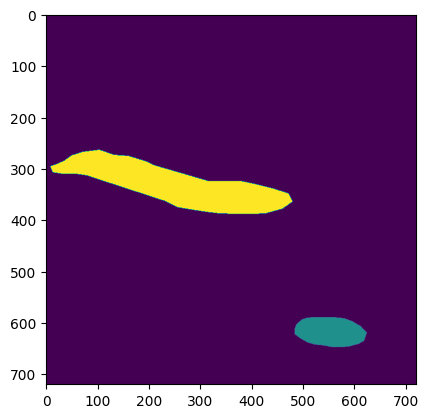

In [14]:
if __name__ == "__main__":


    ## Ask the below inputs from the User

    
    json_file = "../Dataset/AnnotatedJSON/AnnotatedJSON.json"
    image_root = "../Dataset/AnnotatedImages"
    output_folder = "../Dataset/aug"
    list_augmentations_file = "Augmentations"
    hasKeypoints = True
    hasBBox = True
    hasSeg = True
    Augmentation = False
    split = False
    Val_Split = 0.25
    JSON_type = "Custom" ##Default COCO or Custom

    ## 1. Load the JSON file 
    ## 2. Load the augmentation file
    ## 3. Make a directory to save Augmented Images
    ## 4. Specify the maximum number of keypoints an Image could contain

    with open(json_file) as f:
        img_annotations = json.load(f)

    if Augmentation == True:
        directory = "AugImages"
        augFile = open(list_augmentations_file, 'r')
        augTransforms = augFile.readlines()
    elif JSON_type == "Custom":
        directory = "Images"
    elif JSON_type == "COCO":
        print("Since the JSON type is COCO, please select Augmentations or train the COCO dataset directly")
        sys.exit()

    output_folder = output_folder + "/"
    image_root = image_root + "/"
    path_toAug = os.path.join(output_folder, directory)
    os.mkdir(path_toAug)

    maxNumOfKeypoints = 0
    if hasKeypoints == True:
        VisualizeKeypoints = True   ## give only if your dataset has keypoints   ##Argument 8
    processedAnnotations = []
    if JSON_type == "Custom":
        processedAnnotations = CreateCOCOJSON_fromJSON_MIN(img_annotations,path_toAug,json_file,image_root,output_folder,hasKeypoints,hasBBox,hasSeg,Augmentation,maxNumOfKeypoints)
    elif JSON_type == "COCO":
        processedAnnotations = AugmentCOCO(img_annotations,path_toAug,json_file,image_root,output_folder,hasKeypoints,hasBBox,hasSeg,Augmentation,maxNumOfKeypoints)
    else:
        print('here')
        processedAnnotations = img_annotations
    

    if split == True:
        Coco_split(processedAnnotations, output_folder, path_toAug,Val_Split)
        if Augmentation == True:
            JsonPathAug = output_folder +"CocoAugJSON"
            shutil.rmtree(path_toAug, ignore_errors=True)
            shutil.rmtree(JsonPathAug, ignore_errors=True)


